### Dual Averaging MPI


In [1]:
import numpy as np
import random
from typing import NamedTuple
from  scipy.special import softmax
import matplotlib.pyplot as plt


In [2]:

S = 2
A = 3
S_set = np.arange(S)
A_set = np.arange(A)
gamma = 0.6

#例1.5準拠
#g(s,a)
g = np.zeros((S,A))
g[0][0] = 5
g[0][1] = 10
g[0][2] = 2
g[1][0] = 1


#P(s'|s,a)
P = np.zeros((S,S,A))
P[0][0][0] = 0.8
P[1][0][0] = 0.2
P[1][0][1] = 1
P[0][0][2] = 1
P[1][1][0] = 1
P = np.transpose(P, (1, 2, 0))


class MDP(NamedTuple):
    S_set: np.array  # 状態集合
    A_set: np.array  # 行動集合
    gamma: float  # 割引率
    g: np.array  # 報酬行列
    P: np.array  # 遷移確率行列
    mu: np.array

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_set)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_set)

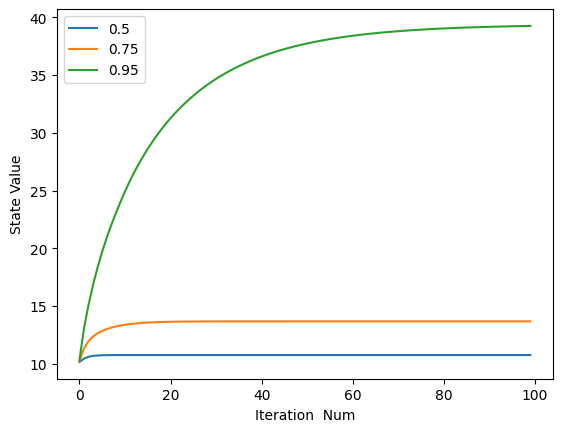

In [10]:
pi = np.zeros((S,A))
#決定的方策を作成
#softmax方策を作る必要がある
pi[0][0] = 1
pi[1][1] = 1
v = np.zeros(S)
entropy_term = 0.1
mu = []
mdp2 = MDP(S_set, A_set, 0.5, g, P,mu)


_lambda = 0.1
tau = 0.1
#regularized greedy policyの定義
def KL_divergence(p, q):
    return np.sum(p * (np.log(p)-np.log(q)))

def entropy(p):
    return -np.sum(p * np.log(p))

#πの集合、muはどうやって定義するのか
PI = []

def compute_Q_pi(mdp2,Q,pi):
    S,A = mdp2.S,mdp2.A
    v = np.sum(pi * Q,axis = 1) #piとQの内積
    P_v = P @ (v -  0.1 * np.sum( pi * np.log(pi+1e-8),axis = 1)+ tau * entropy(pi)) #Pと(v - 正則化項)との内積
    Q_pi = g + mdp2.gamma * P_v # T 
    return Q_pi

updated_v = v
gammas = [0.5,0.75,0.95]
for gamma in gammas:
    mdp2 = mdp2._replace(gamma=gamma)
    v_value = []
    pi = np.ones((S,A))/A
    Q = np.zeros((S,A))
    for i in range(100):
        Q= compute_Q_pi(mdp2,Q,pi)
        pi = softmax(Q,axis=1)
        v_value.append(Q.max())
    plt.plot(v_value,label = f"{gamma}")

plt.ylabel("State Value")
plt.xlabel("Iteration  Num")

plt.legend()

C:\Users\throb\AppData\Local\Temp\ipykernel_3432\1702052317.py:21: RuntimeWarning: divide by zero encountered in log
  return -np.sum(p * np.log(p))
C:\Users\throb\AppData\Local\Temp\ipykernel_3432\1702052317.py:21: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(p * np.log(p))


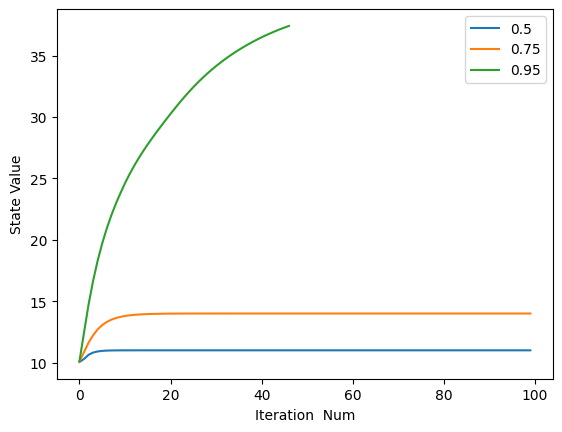

In [34]:
#DA-MPI tau = 0の場合

pi = np.zeros((S,A))
pi[0][0] = 1
pi[1][1] = 1
v = np.zeros(S)
entropy_term = 0.1
mu = []
mdp2 = MDP(S_set, A_set, 0.5, g, P,mu)


_lambda = 0.1
tau = 0
tau_not0 = 0.1
beta = _lambda /(_lambda + tau_not0)
#regularized greedy policyの定義
def KL_divergence(p, q):
    return np.sum(p * (np.log(p)-np.log(q)))

def entropy(p):
    return -np.sum(p * np.log(p))


def compute_Q_pi(mdp2,Q,pi,tau):
    S,A = mdp2.S,mdp2.A
    v = np.sum(pi * Q,axis = 1) #piとQの内積
    P_v = P @ (v -  _lambda * np.sum( pi * np.log(pi+1e-8),axis = 1)+ tau * entropy(pi)) #Pと(v - 正則化項)との内積
    Q_pi = g + mdp2.gamma * P_v # T 
    return Q_pi

def compute_h(Q,h,k):
    #tau = 0の場合
    if k == 0:
        return(0) + Q * (1/(k+2))
    else:
        return  ((k+1)/(k+2)) * h + (1/k+2) * Q

def compute_h_tau_not0(Q,h,k):
    #tau = 0の場合
    if k == 0:
        return(0) + (1 - beta) * Q
    else:
        return  beta * h + (1 - beta) * Q


updated_v = v
gammas = [0.5,0.75,0.95]
for gamma in gammas:
    mdp2 = mdp2._replace(gamma=gamma)
    v_value = []
    pi = np.ones((S,A))/A
    Q = np.zeros((S,A))
    h = Q
    k = 0
    for i in range(100):
        Q= compute_Q_pi(mdp2,Q,pi,tau)
        h = compute_h(Q,h,k)
        pi = softmax(h,axis=1)
        v_value.append(Q.max())
        k+=1
    plt.plot(v_value,label = f"{gamma}")

plt.ylabel("State Value")
plt.xlabel("Iteration  Num")

plt.legend()

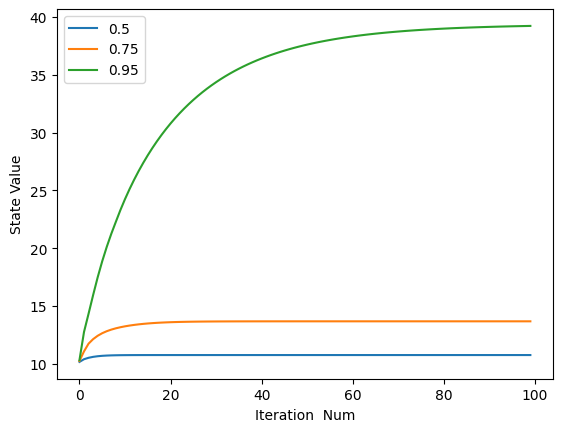

In [35]:
#DA-MPI tau not = 0の場合

updated_v = v
gammas = [0.5,0.75,0.95]
for gamma in gammas:
    mdp2 = mdp2._replace(gamma=gamma)
    v_value = []
    pi = np.ones((S,A))/A
    Q = np.zeros((S,A))
    h = Q
    k = 0
    for i in range(100):
        Q= compute_Q_pi(mdp2,Q,pi,tau_not0)
        h = compute_h_tau_not0(Q,h,k)
        pi = softmax(h,axis=1)
        v_value.append(Q.max())
        k+=1
    plt.plot(v_value,label = f"{gamma}")

plt.ylabel("State Value")
plt.xlabel("Iteration  Num")

plt.legend()

### 理論解析
